In [19]:
import pandas as pd
from joblib import load
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [20]:
class CreditRiskDataLoader:
    def __init__(self, x_data_path, y_data_path):
        self.x_data_path = x_data_path
        self.y_data_path = y_data_path
        self.X = None
        self.y = None

    def load_data(self):
        self.X = pd.read_csv(self.x_data_path)
        self.y = pd.read_csv(self.y_data_path)
        return self.X, self.y
    
    def preprocess_data_from(self, path):
        data = pd.read_csv(path)
        self.y = data['loan_status']
        data.drop(['loan_status'], axis=1, inplace=True)
        self.X = data
        self.X = self.X.drop_duplicates()
        self.X = self.X.dropna()
        self.X = pd.get_dummies(self.X, columns=['person_home_ownership', 'loan_intent'])
        mapping = {
            'A': 0, 
            'B': 1, 
            'C': 2, 
            'D': 3, 
            'E': 4, 
            'F': 5, 
            'G': 6, 
            }
        self.X['loan_grade'] = self.X['loan_grade'].map(mapping)
        mapping1 = {
            'N': 0, 
            'Y': 1, 
            }
        self.X['cb_person_default_on_file'] = self.X['cb_person_default_on_file'].map(mapping1)
        self.X.info()
        
        return self.X, self.y


In [21]:
x_data_path = "data/test_dataset.csv"
y_data_path = "data/test_dataset_label.csv"
data_path = "data/credit_risk_dataset.csv"
models = [
    #'models/RFC_model.joblib',
    #'models/RFC_under_model.joblib',
    #'models/XGB_under_model.joblib',
    'models/XGB_model.joblib'
    ]

In [22]:
data_loader = CreditRiskDataLoader(x_data_path, y_data_path)
X_test, y_test = data_loader.load_data()
# X_test, y_test = data_loader.preprocess_data_from_file(data_path)

Evaluation results for models/XGB_model.joblib:
Accuracy: 0.9343974741273461
Precision: 0.9643605870020965
Recall: 0.7301587301587301
F1 Score: 0.8310749774164409
ROC AUC: 0.9445168219655949
Confusion Matrix:
[[4407   34]
 [ 340  920]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4441
           1       0.96      0.73      0.83      1260

    accuracy                           0.93      5701
   macro avg       0.95      0.86      0.90      5701
weighted avg       0.94      0.93      0.93      5701




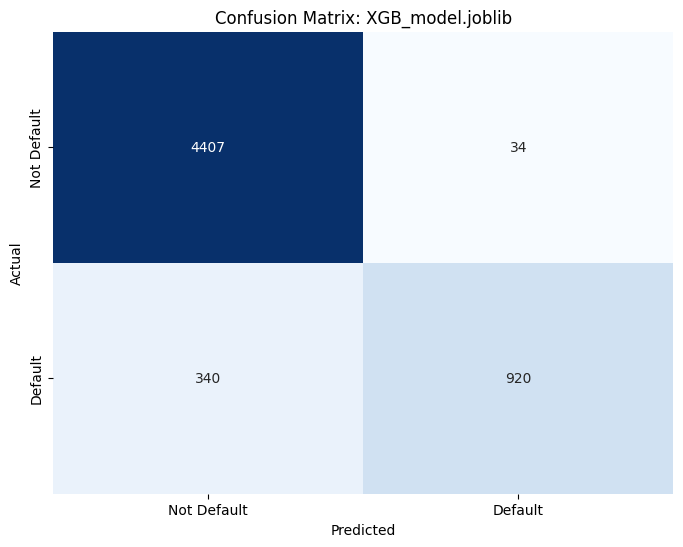

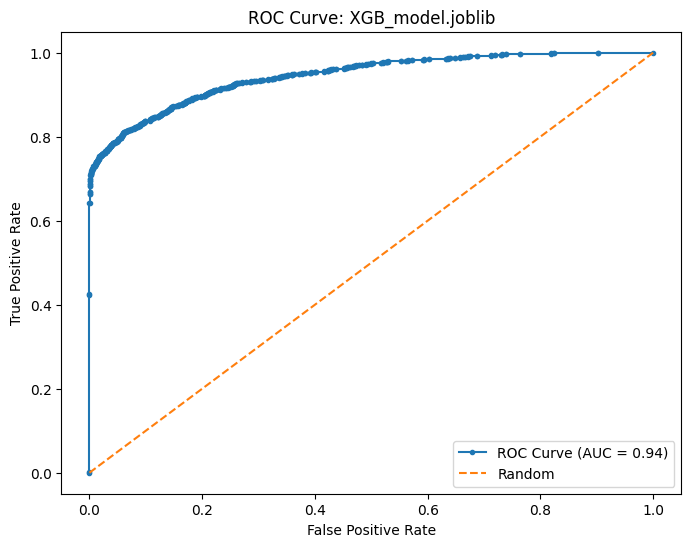

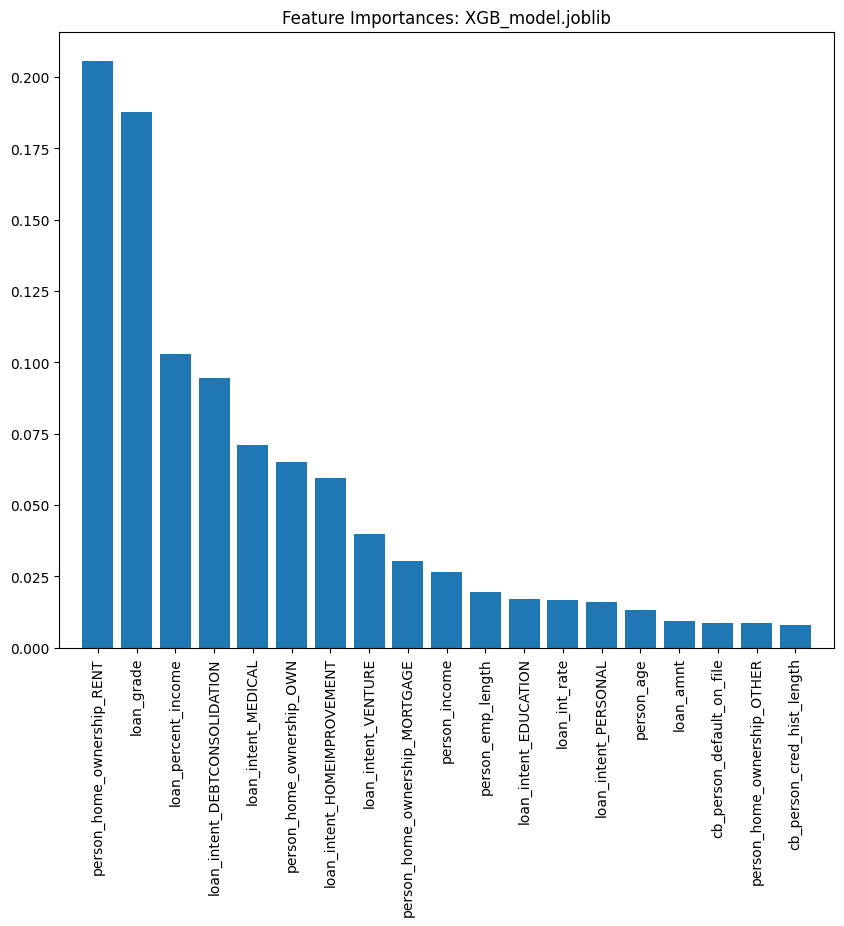

In [23]:
for model_path in models:
        model = load(model_path)
        
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        cm = confusion_matrix(y_test, y_pred)
        clf_report = classification_report(y_test, y_pred)
        
        print(f"Evaluation results for {model_path}:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"ROC AUC: {roc_auc}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{clf_report}")
        print()

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Default', 'Default'], yticklabels=['Not Default', 'Default'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix: {model_path.split("/")[-1]}')
        plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, marker='.', label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve: {model_path.split("/")[-1]}')
        plt.legend()
        plt.show()

        if hasattr(model.named_steps['classifier'], 'feature_importances_'):
            feature_importances = model.named_steps['classifier'].feature_importances_
            features = X_test.columns
            indices = np.argsort(feature_importances)[::-1]
            plt.figure(figsize=(10, 8))
            plt.title(f'Feature Importances: {model_path.split("/")[-1]}')
            plt.bar(range(X_test.shape[1]), feature_importances[indices], align='center')
            plt.xticks(range(X_test.shape[1]), features[indices], rotation=90)
            plt.xlim([-1, X_test.shape[1]])
            plt.show()